# Tomato Disease classification

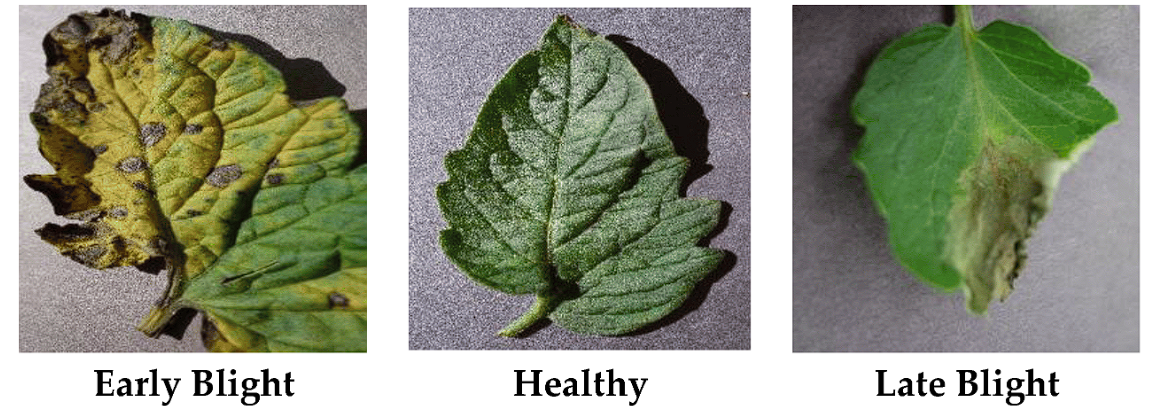

## 1. Loading Dataset

In [1]:
# prompt: unzip the archive.zip file
!unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
# importing librarires
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

2024-03-24 17:11:54.796608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 17:11:54.796717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 17:11:55.075734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
IMAGE_SIZE = 256  # EAch image is 256*256 pixels
BATCH_SIZE = 32   # general tendency to take 32 as batch size

CHANNELS = 3 #RGB
EPOCHS = 100

In [5]:
# creating the dataset consisting of 3 folders

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomato-classification/archive/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4496 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names

In [7]:
#these are subfolder names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [8]:
len(dataset) #because 141*32

141

In [9]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].shape)

(256, 256, 3)


## 2. Visulizing the Images

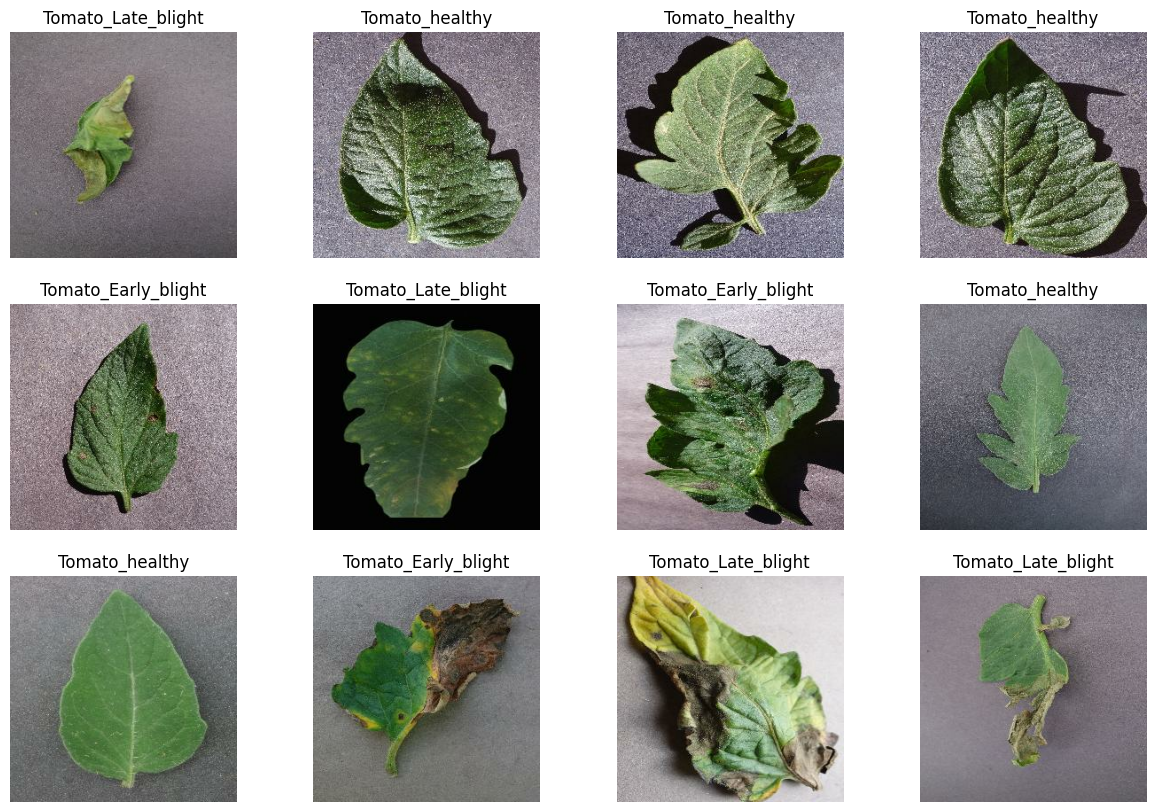

In [10]:
plt.figure(figsize=(15, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

## 3. Train Test Val Splitting

80% ==> training

20% ==> 10% validation, 10% test


In [11]:
len(dataset)

141

In [12]:
train_size = 0.8
len(dataset)*train_size

112.80000000000001

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)

In [15]:
len(test_ds)

87

In [16]:
val_size=0.1
len(dataset)*val_size

14.100000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

81

### 3.1 Fuction to partiton dataset

In [19]:
# creating a Function to perform above actions of splitting dataset
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size= len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds =get_dataset_partition_tf(dataset)

In [21]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

112
15
14


### 3.2 Caching

keeps image in memory for next iteration(saves time)

In [22]:
# caching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## 4. Data Preprocessing and Augmentation

In [23]:
# rescaling and resizing the images
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [24]:
# Data Augmentation
data_augmentaiton = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## 5. Model Building

### 5.1 Model Architectue

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentaiton,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
    ])


model.build(input_shape = input_shape)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

### 5.2 Model Compiling

In [27]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

### 5.3 Model Fitting

In [28]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/100


I0000 00:00:1711300356.687963     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/112 [==============================] - 30s 108ms/step - loss: 0.8562 - accuracy: 0.5863 - val_loss: 0.7955 - val_accuracy: 0.6607
Epoch 2/100
112/112 [==============================] - 6s 56ms/step - loss: 0.4339 - accuracy: 0.8192 - val_loss: 0.3613 - val_accuracy: 0.8326
Epoch 3/100
112/112 [==============================] - 6s 56ms/step - loss: 0.3704 - accuracy: 0.8405 - val_loss: 0.5271 - val_accuracy: 0.7567
Epoch 4/100
112/112 [==============================] - 6s 56ms/step - loss: 0.3507 - accuracy: 0.8484 - val_loss: 0.3519 - val_accuracy: 0.8393
Epoch 5/100
112/112 [==============================] - 6s 56ms/step - loss: 0.2876 - accuracy: 0.8842 - val_loss: 0.4883 - val_accuracy: 0.7790
Epoch 6/100
112/112 [==============================] - 6s 56ms/step - loss: 0.2769 - accuracy: 0.8800 - val_loss: 0.3212 - val_accuracy: 0.8549
Epoch 7/100
112/112 [==============================] - 6s 56ms/step - loss: 0.3246 - accuracy: 0.8739 - val_loss: 0.2837 - val_accuracy: 0.8549
Ep

### close to 99% validation accuracy achieved

## 6. Model Evaluation

In [29]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 6s 25ms/step - loss: 0.0319 - accuracy: 0.9875


In [30]:
# first parameter is loss Second is Accuracy
scores

[0.031910259276628494, 0.987500011920929]

### Achieved 99.21% Accuracy on Testing

In [31]:
# check what kind of obj is history, and see official documentation
history

In [32]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 112}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.5863228440284729,
 0.8192264437675476,
 0.8405268788337708,
 0.8483744263648987,
 0.8842488527297974,
 0.8800448179244995,
 0.8738788962364197,
 0.8901345133781433,
 0.8906950950622559,
 0.9063901305198669,
 0.8988228440284729,
 0.9083520174026489,
 0.9145179390907288,
 0.9167600870132446,
 0.926008939743042,
 0.9302130341529846,
 0.9215246438980103,
 0.9346973299980164,
 0.9380605220794678,
 0.9344170689582825,
 0.9304932951927185,
 0.9487107396125793,
 0.933576226234436,
 0.9442264437675476,
 0.9492713212966919,
 0.9461883306503296,
 0.9375,
 0.9593609571456909,
 0.9627242088317871,
 0.9576793909072876,
 0.9613228440284729,
 0.963004469871521,
 0.9548766613006592,
 0.9588004350662231,
 0.9677690863609314,
 0.9624439477920532,
 0.9700112342834473,
 0.9624439477920532,
 0.9747757911682129,
 0.9795403480529785,
 0.9573991298675537,
 0.9680493474006653,
 0.9792600870132446,
 0.9641255736351013,
 0.9694506525993347,
 0.9733744263648987,
 0.9798206090927124,
 0.9700112342834473,
 0.9801

### 6.1 Plotting the Accuracy

In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]


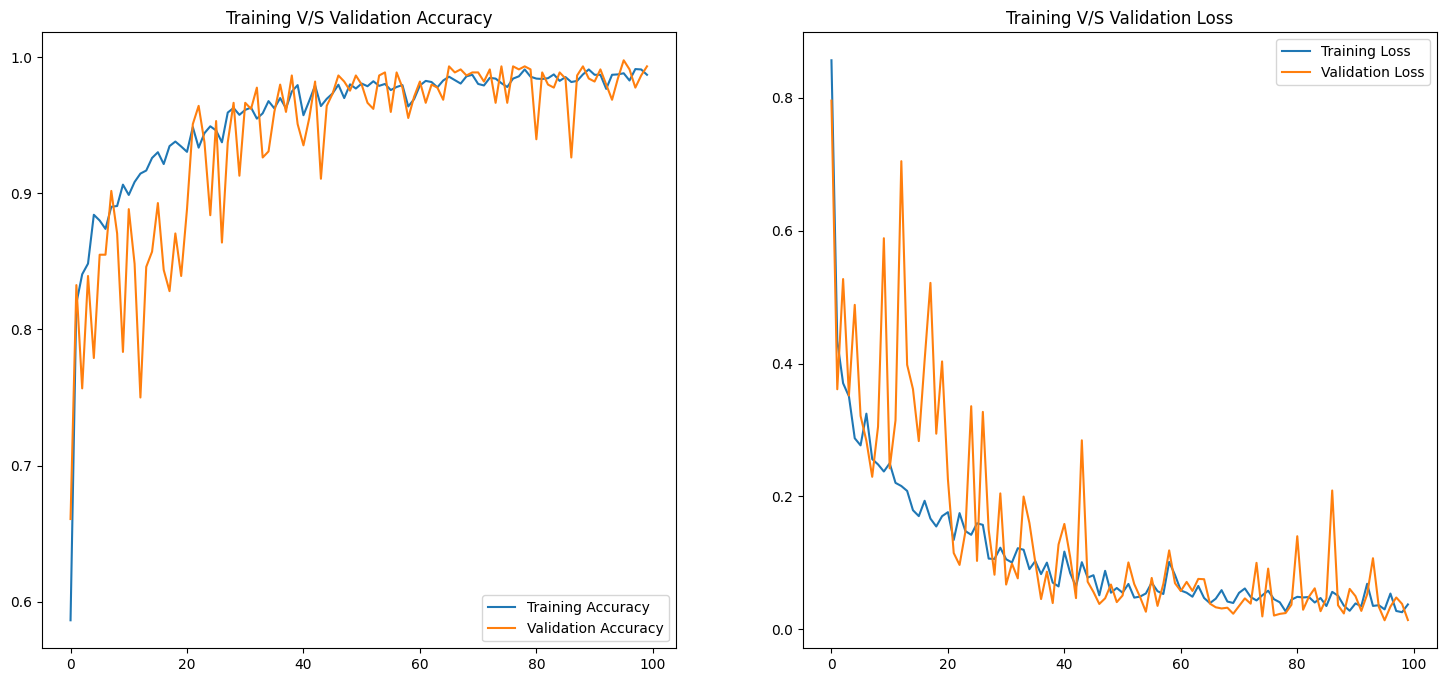

In [36]:
# Plotting training vs validation accuracy

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training V/S Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training V/S Validation Loss")
plt.show()

## 7. Prediciton and Inferences

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 0s 157ms/step
predicted label: Tomato_healthy


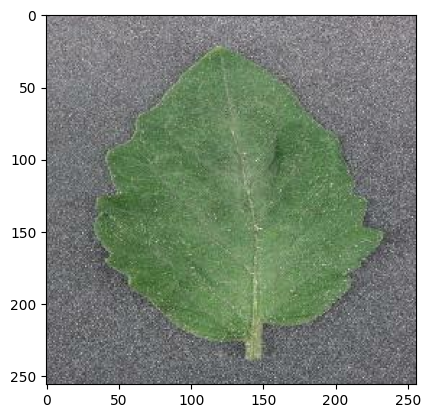

In [37]:
#test

for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
#defining a prediction function

def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_arry = tf.expand_dims(img_array, 0) # Create a batch

  prediction = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=False
      • mask=None


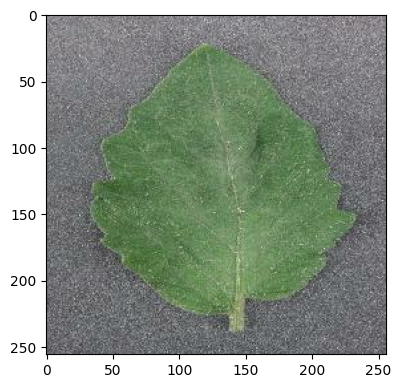

In [42]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")

    plt.axis("off")

## 8. Saving the model

In [44]:
import os

# List only directories in "/content" and filter out non-integer directories
directories = [d for d in os.listdir("/kaggle/working/") if os.path.isdir(os.path.join("/kaggle/working/", d)) and d.isdigit()]

# Convert directory names to integers and find the maximum
if directories:
    model_version = max(map(int, directories)) + 1
else:
    model_version = 1  # If no directories found, start with version 1


In [47]:

model.save(f"Model_{model_version}")

### 8.1 converting it to zipfile

In [46]:
import zipfile

In [49]:
# Replace '/kaggle/working/' with the actual path to your folder
with zipfile.ZipFile('Tomato_model.zip', 'w') as zip_file:
    for root, dirs, files in os.walk('/kaggle/working/'):
        for file in files:
            zip_file.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join('your_folder/', '..')))
